In [246]:
import pandas as pd
import numpy as np

## Reading some buckets of sales data 

In [247]:
train_data1 = pd.read_csv('../data/interim/train_2013-11_to_2014-12.csv', parse_dates=['date'])
val_data1 = pd.read_csv('../data/interim/val_2015-1.csv', parse_dates=['date'])

train_data2 = pd.read_csv('../data/interim/train_2013-1_to_2015-4.csv', parse_dates=['date'])
val_data2 = pd.read_csv('../data/interim/val_2015-5.csv', parse_dates=['date'])

train_data3 = pd.read_csv('../data/interim/train_2013-6_to_2015-6.csv', parse_dates=['date'])
val_data3 = pd.read_csv('../data/interim/val_2015-7.csv', parse_dates=['date'])

train_data4 = pd.read_csv('../data/interim/train_2013-3_to_2015-7.csv', parse_dates=['date'])
val_data4 = pd.read_csv('../data/interim/val_2015-8.csv', parse_dates=['date'])

### And additional tables

In [248]:
shops = pd.read_csv('../data/interim/shops_appearence.csv', parse_dates=['shop_appearence'])
items = pd.read_csv('../data/interim/items_appearence.csv', parse_dates=['item_appearence'])
item_cat = pd.read_csv('../data/interim/item_categories_global.csv')
sales_pivot = pd.read_csv('../data/interim/sales_pivot.csv')
datasets = {'shops': shops, 'items': items, 'item_categories': item_cat, 'sales_lags': sales_pivot}

## Feature extraction

I decided to define feature extraction layer as a pipeline that modifies initial data step by step. Here ate the steps:

1) getting `month` from `date` and encoding it

2) merging with `items`, `shops` and `item_categories` tables to add information (such as `city`, `item_category` and `global_category` features)

3) calculating how long both item and shop are present in dataset

4) grouping by month and calculating montly sales feature, our target

5) adding previous month sales (1, 3, 6 and 12 month ago)


In [249]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [284]:
class MonthFromDate(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['month'] = X['date_block_num'] % 12 + 1
        X['month_sin'] = np.sin(2 * np.pi * X['month']/12.0)
        X['month_cos'] = np.cos(2 * np.pi * X['month']/12.0)
        X.drop(['month'], axis=1, inplace=True) 
#        print('Month encoding stage complete')

        return X
    
class ShopItemAge(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['shop_age_month'] = (X['date'] - X['shop_appearence']).dt.days / 30
        X['item_age_month'] = (X['date'] - X['item_appearence']).dt.days / 30
        X.drop(['shop_appearence','item_appearence','date'], axis=1, inplace=True) 

#        print('Item and shop ages calculation complete')
        return X
    
class MonthlySales(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X = X.groupby(['date_block_num','item_id', 'shop_id']).agg({'item_cnt_day':'sum',
                                                                    'date':'max',
                                                                   }).reset_index().rename({'item_cnt_day':'item_cnt_month'}, axis=1)
#        print('Monthly sales calculated')
        
        return X

class MergeTables(BaseEstimator, TransformerMixin):
    def __init__(self, lookup_tables):
        self.items = lookup_tables['items']
        self.shops = lookup_tables['shops']
        self.item_cat = lookup_tables['item_categories']
        self.sales_lags = lookup_tables['sales_lags']
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X = X.merge(self.items, on='item_id', how='left')
        X = X.merge(self.shops, on='shop_id', how='left')
        X = X.merge(self.item_cat, on='item_category_id', how='left')
        X = X.merge(self.sales_lags, on=['item_id', 'shop_id'], how='left')
        X['item_appearence'] = X['item_appearence'].fillna(X['date'])
        X['shop_appearence'] = X['shop_appearence'].fillna(X['date'])
        X = X.fillna(0)
        X.drop(['item_name', 'shop_name', 'item_category_name', 'city', 'global_cat'], axis=1, inplace=True)
#        print('Merging stage complete')
        return X

class GetLagFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, lags, df):
        self.lags = lags
        self.sales_lags = df
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X = X.merge(self.sales_lags, on=['item_id', 'shop_id'], how='left')
        X = X.fillna(0)
        for lag in self.lags:
            X[f'month_lag_{lag}'] = 0
            
        for i,lag in enumerate(self.lags):
            for date_block in X['date_block_num'].unique():
                if date_block - lag >= 0:
                    X.loc[X['date_block_num'] == date_block, f'month_lag_{lag}'] = X.loc[X['date_block_num'] == date_block][f'{date_block-lag}']
#            print(f'Lag features calculated {i+1}/{len(self.lags)}')
        X.drop([str(i) for i in range(0, 34)], axis=1, inplace=True) 
        X.drop(['date_block_num'], axis=1, inplace=True) 

        return X

extraction_steps = [("montly_sales", MonthlySales()),
                ("month_feat", MonthFromDate()),
                ("merge", MergeTables(datasets)),
                ("ages", ShopItemAge())
            ]
        
feature_extraction_pipeline = Pipeline(steps=extraction_steps)

In [370]:
class GetLagSales(BaseEstimator, TransformerMixin):
    def __init__(self, lags):
        self.lags = lags
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].iloc[0]
        for lag in self.lags:
            if date_block - lag >= 0:
                X[f'month_lag_{lag}'] = X.loc[:, str(int(date_block-lag))]
            else:
                X[f'month_lag_{lag}'] = 0
        return X
    
class GetSumOfSales(BaseEstimator, TransformerMixin):
    def __init__(self, lags):
        self.lags = lags
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].iloc[0]
        for lag in self.lags:
            cols_to_sum = [str(int(date_block-i)) for i in range(1, lag + 1) if date_block-i >= 0]
            X[f'sum_sales_lag_{lag}'] = X.loc[:,cols_to_sum].sum(axis=1)
        return X.drop([str(i) for i in range(34)], axis=1)
    
    
lag_steps = [("past_month_sales", GetLagSales([1,2,3,6,12])),
                ("summed_sales", GetSumOfSales([6,12]))
            ]
        
lag_pipeline = Pipeline(steps=lag_steps)

### Choosing best training data subset

In [251]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
from datetime import datetime

In [256]:
def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

In [373]:
def compare_models(models):
    result = []
    fold = 1

    with tqdm(total=(len(models) + 1) * 4) as pbar:
        for val, train in zip([val_data1, val_data2, val_data3, val_data4], [train_data1, train_data2, train_data3, train_data4]):

            train = feature_extraction_pipeline.fit_transform(train)
            train_per_month = [lag_pipeline.fit_transform(train.loc[train['date_block_num'] == block].copy()) for block in train['date_block_num'].unique()]
            train = pd.concat(train_per_month, axis=0)
            
            val = feature_extraction_pipeline.transform(val)
            val = lag_pipeline.transform(val)
            
            pbar.update(1)

            val_x, val_y = x_y_split(val, 'item_cnt_month')
            train_x, train_y = x_y_split(train, 'item_cnt_month')

            for model_name, model in models.items():
                fit_time_start = datetime.now()
                model.fit(train_x, train_y)
                fit_time_end = datetime.now()
                result.append({'model' : model_name,
                               'fold' : fold,
                               'data_size' : train_x.shape[0],
                               'fit_time' : (fit_time_end - fit_time_start).seconds,
                               'val_mse' : mean_squared_error(val_y, model.predict(val_x)),
                               'train_mse' : mean_squared_error(train_y, model.predict(train_x))})
                pbar.update(1)
            fold += 1
            
    return result

In [375]:
model_dict = {'RFR' : RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=1001),
             'KNN': KNeighborsRegressor(),
             'LR':LinearRegression(),
             'XGBR':XGBRegressor(n_jobs=-1, random_state=1001)}

result_df = pd.DataFrame(compare_models(model_dict))
result_df

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [254]:
import seaborn as sns

def plot_results(result_df):
    sns.set(rc={'figure.figsize':(11,8)})
    tmp1 = result_df.drop(['val_mse'], axis=1).rename(columns={'train_mse' : 'mse'})
    tmp1['type'] = 'train'
    tmp2 = result_df.drop(['train_mse'], axis=1).rename(columns={'val_mse' : 'mse'})
    tmp2['type'] = 'val'
    sns.lineplot(data=tmp1.append(tmp2), x='fold', y='mse', hue='model', style='type');

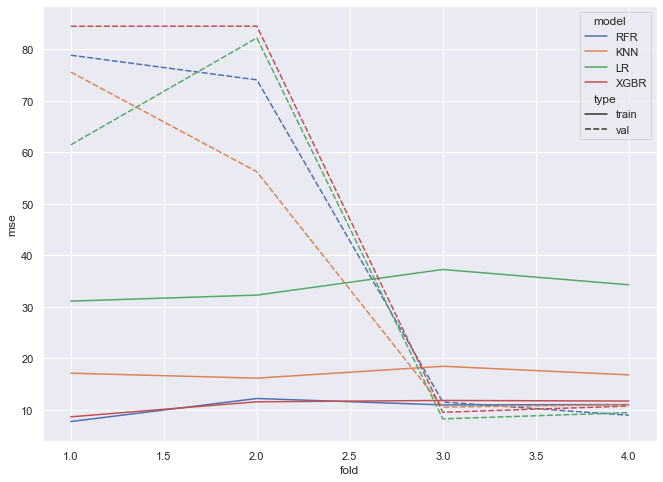

In [255]:
plot_results(result_df)

We can observe overfitting in many cases (except for maybe RFR, XGBR on folds 3-4,). 

All models except for LR performed significantly better on fold 3 and 4.

For now we will choose fold 3 for further experiments, since it's smaller than 4.

## Experiments with models and parameters (no fancy tuning)

In [257]:
train = feature_extraction_pipeline.fit_transform(train_data3)
val = feature_extraction_pipeline.transform(val_data3)

train.to_csv('../data/processed/train_experimental.csv', index=False)
val.to_csv('../data/processed/val_experimental.csv', index=False) 
    
target = 'item_cnt_month'
val_x, val_y = x_y_split(val, target)
train_x, train_y = x_y_split(train, target)

In [258]:
train_x.head()

,item_id,shop_id,month_sin,month_cos,item_category_id,city_id,global_cat_id,shop_age_month,item_age_month,month_lag_1,month_lag_3,month_lag_6,month_lag_12
0,27,25,1.224647e-16,-1.0,19,15,5,5.600000,5.600000,0.0,0.0,0.0,0.0
1,27,32,1.224647e-16,-1.0,19,15,5,5.166667,5.166667,0.0,1.0,0.0,0.0
2,28,28,1.224647e-16,-1.0,30,15,8,5.700000,5.666667,0.0,0.0,0.0,0.0
3,28,30,1.224647e-16,-1.0,30,15,8,5.000000,5.000000,0.0,0.0,0.0,0.0
4,28,47,1.224647e-16,-1.0,30,24,8,5.066667,5.066667,0.0,0.0,0.0,0.0


In [259]:
rfr = RandomForestRegressor(n_estimators=70, max_depth=17, n_jobs=-1, random_state=1001)
rfr.fit(train_x, train_y)
train_mse = mean_squared_error(train_y, rfr.predict(train_x))
val_mse = mean_squared_error(val_y, rfr.predict(val_x))
train_mse, val_mse

(8.306176769662503, 14.422670617399762)

In [260]:
xgbr = XGBRegressor(max_depth=5, n_jobs=-1, random_state=1001, colsample_bytree=0.5)
xgbr.fit(train_x, train_y)
train_mse = mean_squared_error(train_y, xgbr.predict(train_x))
val_mse = mean_squared_error(val_y, xgbr.predict(val_x))
train_mse, val_mse

(17.821552138422696, 8.06647026840468)

In [261]:
knn = KNeighborsRegressor(weights='distance', n_neighbors=11)
knn.fit(train_x, train_y)
train_mse = mean_squared_error(train_y, knn.predict(train_x))
val_mse = mean_squared_error(val_y, knn.predict(val_x))
train_mse, val_mse

(0.0, 8.728137330090965)

#### Trying same models again, this time with scaling and encoded data

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

In [101]:
num_cols = ['shop_age_month', 'item_age_month', 'month_lag_1', 'month_lag_3', 'month_lag_6', 'month_lag_12']
cat_cols = ['shop_id', 'item_id', 'item_category_id', 'global_cat_id', 'city_id']

In [102]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.scaler = StandardScaler()
        self.columns = columns
    def fit(self, X, y=None ):
        self.scaler = self.scaler.fit(X[self.columns])
        return self
    def transform(self, X, y=None):
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X
    
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns, target):
        self.encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
        self.columns = columns
        self.target = target
    def fit(self, X, y=None ):
        X[self.columns] = X[self.columns].astype(object) 
        self.encoder = self.encoder.fit(X[self.columns], X[self.target])
        return self
    def transform(self, X, y=None):
        X[self.columns] = self.encoder.transform(X[self.columns], X[self.target])
        return X


In [103]:
preprocessing_steps = [('feature_scaler', Scaler(num_cols)), ('encoder', Encoder(cat_cols, target))]
target_scaler = StandardScaler()
preprocessing_pipeline = Pipeline(steps=preprocessing_steps)

C:\Users\masha\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\masha\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [121]:
train2 = preprocessing_pipeline.fit_transform(train)
val2 = preprocessing_pipeline.transform(val)

val_x2 = val2.drop(target, axis=1)
val_y2 = val2[target]
train_x2 = train2.drop(target, axis=1)
train_y2 = train2[target]

In [122]:
train_y2_scaled = target_scaler.fit_transform(np.array(train_y2).reshape(-1, 1))
val_y2_scaled = target_scaler.transform(np.array(val_y2).reshape(-1, 1))

In [123]:
train_x2.head()

,item_id,shop_id,month_sin,month_cos,item_category_id,city_id,global_cat_id,shop_age_month,item_age_month,month_lag_1,month_lag_3,month_lag_6,month_lag_12
0,1.00000,2.270891,1.000000e+00,6.123234e-17,2.679186,2.270891,2.605635,-1.485710,-0.845508,-0.183621,-0.163833,-0.131153,-0.090269
1,1.00000,2.270891,-5.000000e-01,-8.660254e-01,2.679186,2.270891,2.605635,-1.065223,-0.368406,-0.183621,-0.163833,-0.131153,-0.090269
2,3.18541,2.270891,1.000000e+00,6.123234e-17,2.679186,2.270891,2.605635,-1.521752,-1.068155,0.409211,-0.163833,-0.131153,-0.090269
3,3.18541,2.270891,-8.660254e-01,-5.000000e-01,2.679186,2.270891,2.605635,-0.905038,-0.368406,-0.183621,-0.163833,0.546909,-0.090269
4,3.18541,2.270891,-2.449294e-16,1.000000e+00,2.679186,2.270891,2.605635,-0.336380,0.276817,-0.183621,-0.163833,-0.131153,-0.090269


In [124]:
train_y2_scaled[:5]

array([[-0.1513707 ],
       [-0.1513707 ],
       [-0.1513707 ],
       [-0.1513707 ],
       [ 1.13709891]])

In [125]:
target_scaler.inverse_transform(train_y2_scaled)[:5]

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [12.]])

In [126]:
result = []
fold = 1
models = [RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=1001),
          #KNeighborsRegressor(),
          LinearRegression(),
          XGBRegressor(n_jobs=-1, random_state=1001)]
model_type = ['RFR','LR', 'XGBR']

with tqdm(total=len(model_type) * 4) as pbar:
    for val, train in zip([val_data1, val_data2, val_data3, val_data4], [train_data1, train_data2, train_data3, train_data4]):
        
        train = feature_extraction_pipeline.fit_transform(train)
        train = preprocessing_pipeline.fit_transform(train)
        val = feature_extraction_pipeline.transform(val)
        val = preprocessing_pipeline.transform(val)
        
        val_x = val.drop(target, axis=1)
        val_y = val[target]
        train_x = train.drop(target, axis=1)
        train_y = train[target]
        
        train_y_scaled = target_scaler.fit_transform(np.array(train_y).reshape(-1, 1))
        val_y_scaled = target_scaler.transform(np.array(val_y).reshape(-1, 1))

        for i, model in enumerate(models):
            fit_time_start = datetime.now()
            model.fit(train_x, train_y_scaled.ravel())
            fit_time_end = datetime.now()
            y_pred = model.predict(val_x)
            pred_time_end = datetime.now()
            y_pred_inv = target_scaler.inverse_transform(y_pred)
            result.append({'model' : model_type[i],
                           'fold' : fold,
                           'data_size' : train_x.shape[0],
                           'fit_time' : (fit_time_end - fit_time_start).seconds,
                           'pred_time' : (pred_time_end - fit_time_end).seconds,
                           'val_mse' : mean_squared_error(val_y, y_pred_inv),
                           'train_mse' : mean_squared_error(train_y, target_scaler.inverse_transform(model.predict(train_x)))})
            pbar.update(1)
        fold += 1

  0%|          | 0/12 [00:00<?, ?it/s]

<ipython-input-126-1b5d452ba487>:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y_scaled)
<ipython-input-126-1b5d452ba487>:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y_scaled)
<ipython-input-126-1b5d452ba487>:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y_scaled)
<ipython-input-126-1b5d452ba487>:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y_scaled)


In [127]:
result_df2 = pd.DataFrame(result)
result_df2

,model,fold,data_size,fit_time,pred_time,val_mse,train_mse
0,RFR,1,684007,71,0,0.807328,0.057805
1,LR,1,684007,0,0,0.753870,0.345002
2,XGBR,1,684007,15,0,0.855588,0.058246
3,RFR,2,1414796,174,0,2.031950,0.086048
4,LR,2,1414796,0,0,1.443614,0.434244
5,XGBR,2,1414796,39,0,1.215954,0.100443
6,RFR,3,1184065,146,0,0.148644,0.069230
7,LR,3,1184065,0,0,0.184113,0.428946
8,XGBR,3,1184065,34,0,0.098957,0.081761
9,RFR,4,1389338,174,0,0.125993,0.074649


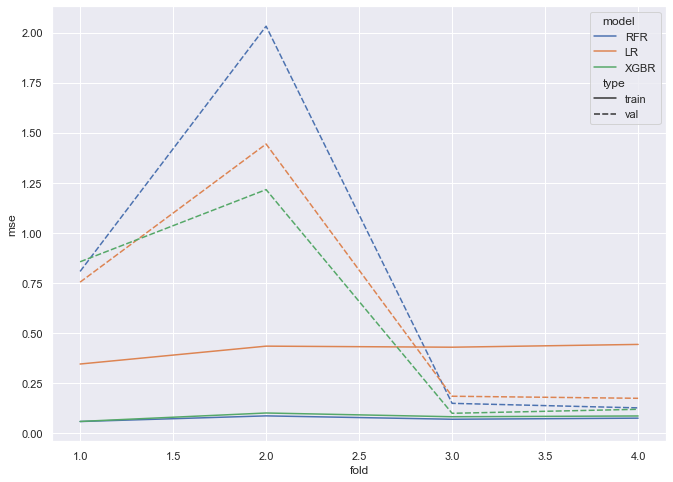

In [128]:
sns.set(rc={'figure.figsize':(11,8)})
tmp1 = result_df2.drop(['val_mse'], axis=1).rename(columns={'train_mse' : 'mse'})
tmp1['type'] = 'train'
tmp2 = result_df2.drop(['train_mse'], axis=1).rename(columns={'val_mse' : 'mse'})
tmp2['type'] = 'val'
sns.lineplot(data=tmp1.append(tmp2), x='fold', y='mse', hue='model', style='type');

Looks pretty similar, RFR and XGBR performing best on folds 3-4.

In [136]:
rfr = RandomForestRegressor(n_estimators=90, max_depth=18, n_jobs=-1, random_state=1001)
rfr.fit(train_x2, train_y2_scaled.ravel())
y_pred2_scaled = rfr.predict(val_x2)

In [137]:
y_pred2_inverse = target_scaler.inverse_transform(y_pred2_scaled)
print(f'inversly scaled target: {y_pred2_inverse}')
print(f'MSE inversly scaled = {mean_squared_error(val_y2, y_pred2_inverse)}')
print(f'MSE initial = {mean_squared_error(val_y2_scaled, y_pred2_scaled)}')

inversly scaled target: [ 1.19817201  1.09885212  1.19242609 ... 23.55616538  4.83097068
  1.02809262]
MSE inversly scaled = 9.692172749128527
MSE initial = 0.13297932892497866


In [ ]:
xgbr = XGBRegressor(n_jobs=-1, random_state=1001)

# Test processing and submission

In [140]:
val_x = val.drop(target, axis=1)
val_y = val[target]
train_x = train.drop(target, axis=1)
train_y = train[target]

train_x.head()

,item_id,shop_id,month_sin,month_cos,item_category_id,city_id,global_cat_id,shop_age_month,item_age_month,month_lag_1,month_lag_3,month_lag_6,month_lag_12
0,27,15,1.000000e+00,6.123234e-17,19,11,5,2.566667,2.533333,0.0,0.0,0.0,0.0
1,27,15,-5.000000e-01,-8.660254e-01,19,11,5,6.066667,6.033333,0.0,0.0,0.0,0.0
2,1407,15,1.000000e+00,6.123234e-17,19,11,5,2.266667,0.900000,5.0,0.0,0.0,0.0
3,1407,15,-8.660254e-01,-5.000000e-01,19,11,5,7.400000,6.033333,0.0,0.0,5.0,0.0
4,1407,15,-2.449294e-16,1.000000e+00,19,11,5,12.133333,10.766667,0.0,0.0,0.0,0.0


In [222]:
from datetime import date

class MonthlySalesTest(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['date_block_num'] = 34
        X['date'] = date(2015, 34 % 12 + 1, 30)
        X['date'] = pd.to_datetime(X['date'], format="%Y-%m-%d")
        return X

pipeline_steps_test = pipeline_steps
pipeline_steps_test[0] = ("montly_sales", MonthlySalesTest())

feature_extraction_pipeline_test = Pipeline(steps=pipeline_steps_test)

In [198]:
test = pd.read_csv('../data/interim/test_etl.csv', index_col='ID')
test.head(), test.shape

(    shop_id  item_id
 ID                  
 0         5     5037
 1         5     5320
 2         5     5233
 3         5     5232
 4         5     5268,
 (214200, 2))

In [240]:
test_x = feature_extraction_pipeline_test.fit_transform(test)
test_x.head(), test_x.shape

(214200, 6)
(214200, 6)
shop_id             False
item_id             False
date_block_num      False
date                False
month_sin           False
month_cos           False
item_name            True
item_category_id     True
item_appearence      True
dtype: bool
{14690}
(214200, 11)
(214200, 10)
(214200, 13)


(   shop_id  item_id  month_sin  month_cos  item_category_id  city_id  \
 0        5     5037       -0.5   0.866025              19.0        5   
 1        5     5320       -0.5   0.866025              55.0        5   
 2        5     5233       -0.5   0.866025              19.0        5   
 3        5     5232       -0.5   0.866025              23.0        5   
 4        5     5268       -0.5   0.866025              20.0        5   
 
    global_cat_id  shop_age_month  item_age_month  month_lag_1  month_lag_3  \
 0            5.0       34.166667       14.833333          0.0          3.0   
 1           12.0       34.166667        0.000000          0.0          0.0   
 2            5.0       34.166667        7.700000          1.0          1.0   
 3            5.0       34.166667        3.733333          0.0          1.0   
 4            5.0       34.166667        0.000000          0.0          0.0   
 
    month_lag_6  month_lag_12  
 0          1.0           1.0  
 1          0.0     

In [141]:
rfr = RandomForestRegressor(n_estimators=70, max_depth=17, n_jobs=-1, random_state=1001)
rfr.fit(train_x, train_y)
train_mse = mean_squared_error(train_y, rfr.predict(train_x))
val_mse = mean_squared_error(val_y, rfr.predict(val_x))
train_mse, val_mse

(8.545596691765521, 8.871586979328535)

In [242]:
y_test = rfr.predict(test_x)
y_test = pd.DataFrame(y_test, columns=['item_cnt_month']).reset_index()
y_test.to_csv('../data/processed/sub_exp.csv', header=['ID', 'item_cnt_month'], index=False)
y_test

,index,item_cnt_month
0,0,1.788466
1,1,1.083406
2,2,1.894598
3,3,1.333744
4,4,4.611447
...,...,...
214195,214195,1.248484
214196,214196,1.377562
214197,214197,1.478128
214198,214198,1.132972


## Feature engineering ideas

* handle outliars
* 

In [ ]:
train_trimmed_idx = (train_y > train_y.quantile(1-.99999)) & (train_y < train_y.quantile(.99999))
val_trimmed_idx = (val_y > train_y.quantile(1-.99999)) & (val_y < train_y.quantile(.99999))

In [ ]:
train_x_trimmed = train_x[train_trimmed_idx]
train_y_trimmed = train_y[train_trimmed_idx]
val_x_trimmed = val_x[val_trimmed_idx]
val_y_trimmed = val_y[val_trimmed_idx]